# Endometrium analysis - clusters visualization

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './data/cellphoneDB_endothelial/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

/home/jovyan/my-conda-envs/myenvSC/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.4 anndata==0.6.22rc1 umap==0.3.10 numpy==1.17.5 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


'/home/jovyan/my-conda-envs/myenvSC/bin/python'

# Prepare INPUT

## Load andata

In [2]:
adata = sc.read('data/endometrium-N2-clean-manifold.h5ad')
adata.X.shape

(65191, 26245)

### Load cell clusters annotation

In [3]:
meta = pd.read_csv('data/cell_annotations/endometrium_cellannotation_clean_20200610.csv')
meta = meta.set_index('index')
meta = meta.drop(['sample', 'individual', 'phase', 'leiden'], axis=1)

### Transfer cluster annotation labels

Remove barcodes not in meta

In [4]:
barcodes = meta.index.tolist()
adata = adata[[ i in barcodes for i in adata.obs_names]]

Now transfer labels

Trying to set attribute `.obs` of view, making a copy.
... storing 'clusters' as categorical


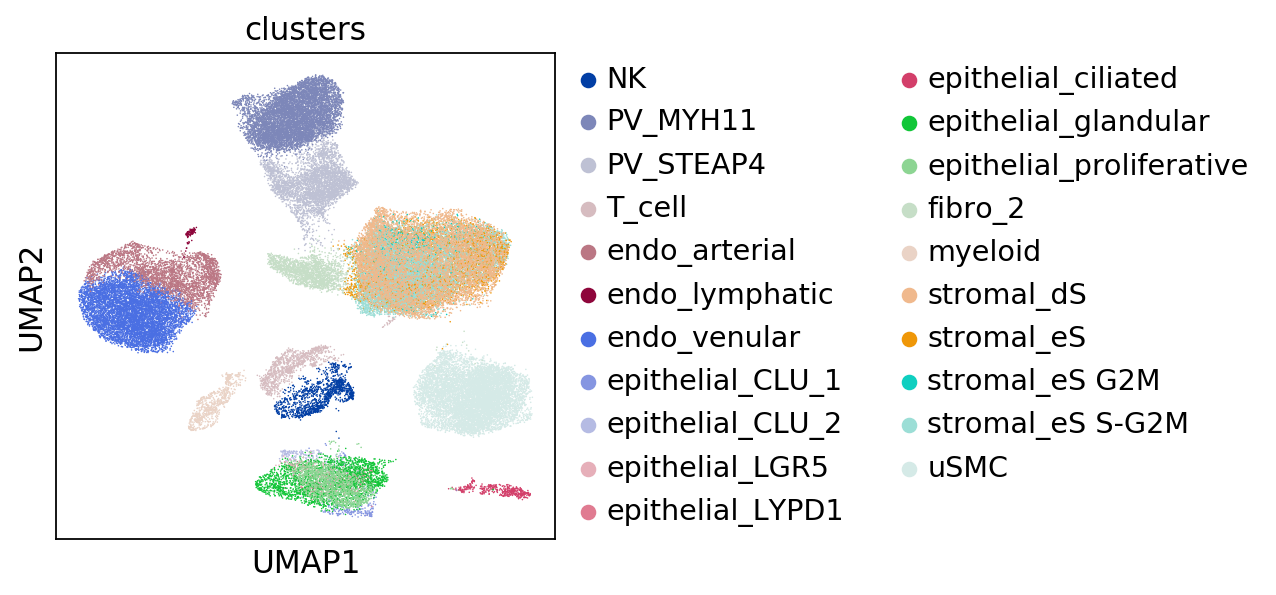

In [5]:
cell_annot = meta['cell_annotation'].to_dict()
adata.obs['clusters'] = [ cell_annot[str(i)] for i in adata.obs_names ]
sc.pl.umap(adata, color=['clusters'])

## Keep endothelial and immune

In [6]:
adata.obs['clusters'].cat.categories

Index(['NK', 'PV_MYH11', 'PV_STEAP4', 'T_cell', 'endo_arterial',
       'endo_lymphatic', 'endo_venular', 'epithelial_CLU_1',
       'epithelial_CLU_2', 'epithelial_LGR5', 'epithelial_LYPD1',
       'epithelial_ciliated', 'epithelial_glandular',
       'epithelial_proliferative', 'fibro_2', 'myeloid', 'stromal_dS',
       'stromal_eS', 'stromal_eS G2M', 'stromal_eS S-G2M', 'uSMC'],
      dtype='object')

In [7]:
adata = adata[[i in ['myeloid', 'NK', 'T_cell', 'endo_arterial', 'endo_venular', 'endo_lymphatic'] for i in adata.obs['clusters'] ]]
adata.obs['clusters'] = adata.obs['clusters'].cat.remove_unused_categories()
adata.obs['clusters'].cat.categories

Trying to set attribute `.obs` of view, making a copy.


Index(['NK', 'T_cell', 'endo_arterial', 'endo_lymphatic', 'endo_venular',
       'myeloid'],
      dtype='object')

## Save gene expression 

Generate the normalized but not log transformed matrix

In [8]:
adata.X.shape

(12988, 26245)

In [9]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, asview=False)
sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
adata_count.X.shape

(12988, 20960)

Use only genes in cellphoneDB to speed up processes

In [10]:
# # load cellphoneDB genes
# genes_df = pd.read_csv('~/farm/CellPhoneDB-data_smallmolecules/data/gene_input_all.csv')
# genes_in_cellphoneDB = list(genes_df['hgnc_symbol'])
# # filter genes in cellphoneDB
# adata_count.var['is_in_cellphoneDB'] = [ i in genes_in_cellphoneDB for i in adata_count.var_names ]
# print(adata_count.var['is_in_cellphoneDB'].value_counts(normalize=True))
# is_in_cellphoneDB = adata_count.var["is_in_cellphoneDB"]
# adata_count = adata_count[:, is_in_cellphoneDB]
# adata_count.X.shape

Save as csv

In [11]:
t = adata_count.X.toarray().T
# Set cell ids as column index and gene ids as row index
df_expr_matrix = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)
df_expr_matrix.to_csv('data/cellphoneDB_endothelial/counts.csv')

## Save meta

In [12]:
df_meta = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ 'celltype_'+str(i) for i in adata_count.obs['clusters']] })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv('data/cellphoneDB_endothelial/meta.tsv', sep = '\t')

# Run cellphoneDB

``
source ~/cpdb-venv/bin/activate
``

## Create database
``
cellphonedb database generate 
    --result-path database 
    --user-gene ~/farm/CellPhoneDB-data_smallmolecules/data/gene_input_all.csv 
    --user-complex ~/farm/CellPhoneDB-data_smallmolecules/data/sources/complex_curated.csv 
    --user-interactions ~/farm/CellPhoneDB-data_smallmolecules/data/sources/interaction_curated.csv
``

## Run cellphone without statistical analysis - just get expressed interactions
``
cellphonedb method analysis /home/jovyan/farm/endometrium/data/cellphoneDB_endothelial/meta.tsv /home/jovyan/farm/endometrium/data/cellphoneDB_endothelial/counts.csv --database /home/jovyan/farm/endometrium/data/cellphoneDB/database/cellphonedb_user_2020-04-27-11_59.db --counts-data hgnc_symbol --output-path /home/jovyan/farm/endometrium/data/cellphoneDB_endothelial/out/ --threshold 0
``


# Compute DEGs

Process data to run limma

In [13]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)
sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
print(adata_count.obs['clusters'].values.describe())
adata_count.X.shape

                counts     freqs
categories                      
NK                1295  0.099707
T_cell            1026  0.078996
endo_arterial     2930  0.225593
endo_lymphatic     101  0.007776
endo_venular      6908  0.531876
myeloid            728  0.056052


(12988, 20960)

prepare objects for R

In [14]:
t = adata_count.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [15]:
meta_df = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ str(i) for i in adata_count.obs['clusters']],
                             'sample':[ str(i) for i in adata_count.obs['individual']],
                             'covariate':[ i for i in adata_count.obs['type']]})
meta_df.head()

,Cell,cell_type,sample,covariate
0,4861STDY7309368_AAACCTGAGATCCTGT,endo_venular,A10,CBTM
1,4861STDY7309368_AAACCTGTCAACACTG,endo_venular,A10,CBTM
2,4861STDY7309368_AAAGATGAGCCCGAAA,endo_venular,A10,CBTM
3,4861STDY7309368_AAAGATGGTCAATGTC,endo_venular,A10,CBTM
4,4861STDY7309368_AAAGCAATCCGTCATC,endo_arterial,A10,CBTM


In [16]:
outpath = str(sc.settings.figdir)

In [17]:
%load_ext rpy2.ipython

In [18]:
%%R -i df -i meta_df -i outpath

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# R modifies colnames, change it back
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

# Intersect shared cells in meta and df
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariate = meta_df$covariate

# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in rev(sort(celltypes))){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster), '\nCells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    design.matrix <- model.matrix(~ 0 + cluster_type)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$cluster = celltype
    results$Gene = rownames(results)
    results = results[ , c('cluster', 'Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    # Round
    results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
    results$AveExpr_rest = round(results$AveExpr_rest, 6)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
    results$percentExpr_rest = round(results$percentExpr_rest, 6)
    
    # and store it as csv file
    write.csv(results, file = paste0(outpath, '/', celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}

[1] "4861STDY7309368_AAACCTGAGATCCTGT" "4861STDY7309368_AAACCTGTCAACACTG"
[3] "4861STDY7309368_AAAGATGAGCCCGAAA"
[1] "4861STDY7309368_AAACCTGAGATCCTGT" "4861STDY7309368_AAACCTGTCAACACTG"
[3] "4861STDY7309368_AAAGATGAGCCCGAAA"


R[write to console]: 12988 shared cells

R[write to console]: T_cell

R[write to console]: Cells in cluster 1026
Cells in rest 11962

R[write to console]: NK

R[write to console]: Cells in cluster 1295
Cells in rest 11693

R[write to console]: myeloid

R[write to console]: Cells in cluster 728
Cells in rest 12260

R[write to console]: endo_venular

R[write to console]: Cells in cluster 6908
Cells in rest 6080

R[write to console]: endo_lymphatic

R[write to console]: Cells in cluster 101
Cells in rest 12887

R[write to console]: endo_arterial

R[write to console]: Cells in cluster 2930
Cells in rest 10058



# Compute DEGs within endothelial

Process data to run limma

In [19]:
adata_count = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs)

#Filter epithelials
adata_count = adata_count[['endo' in i for i in adata_count.obs['clusters'] ]]

sc.pp.filter_genes(adata_count, min_cells = 5)
sc.pp.filter_cells(adata_count, min_genes = 200)
sc.pp.normalize_per_cell(adata_count, counts_per_cell_after=1e4)
sc.pp.log1p(adata_count)
print(adata_count.obs['clusters'].values.describe())
adata_count.X.shape

Trying to set attribute `.var` of view, making a copy.


                counts     freqs
categories                      
endo_arterial     2930  0.294798
endo_lymphatic     101  0.010162
endo_venular      6908  0.695040


(9939, 19559)

prepare objects for R

In [20]:
t = adata_count.X.toarray().T
df = pd.DataFrame(data=t, columns= adata_count.obs.index, index=adata_count.var_names)

In [21]:
meta_df = pd.DataFrame(data={'Cell':list(adata_count.obs.index),
                             'cell_type':[ str(i) for i in adata_count.obs['clusters']],
                             'sample':[ str(i) for i in adata_count.obs['individual']],
                             'covariate':[ i for i in adata_count.obs['type']]})
meta_df.head()

,Cell,cell_type,sample,covariate
0,4861STDY7309368_AAACCTGAGATCCTGT,endo_venular,A10,CBTM
1,4861STDY7309368_AAACCTGTCAACACTG,endo_venular,A10,CBTM
2,4861STDY7309368_AAAGATGAGCCCGAAA,endo_venular,A10,CBTM
3,4861STDY7309368_AAAGATGGTCAATGTC,endo_venular,A10,CBTM
4,4861STDY7309368_AAAGCAATCCGTCATC,endo_arterial,A10,CBTM


In [27]:
outpath = str(sc.settings.figdir)+'/clusterDEGs/DEGs_withinEndothelial/'

In [28]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [29]:
%%R -i df -i meta_df -i outpath

library(limma)
library(edgeR)

# Format
ex_mat=as.matrix(df)
rownames(meta_df) = meta_df$Cell

# R modifies colnames, change it back
rownames(meta_df) = gsub('-', '.', rownames(meta_df))
colnames(ex_mat) = gsub('^X', '', colnames(ex_mat))

# Intersect shared cells in meta and df
shared_cells = intersect(rownames(meta_df), colnames(ex_mat))
print(rownames(meta_df)[1:3])
print(colnames(ex_mat)[1:3])
message(length(shared_cells), ' shared cells')
ex_mat = ex_mat[, shared_cells]
meta_df = meta_df[shared_cells,]

# Filter low expressed genes
keep = aveLogCPM(ex_mat) > 0
ex_mat = ex_mat[ keep, ]

# Extract celltypes
cells = rownames(meta_df)
covariate = meta_df$covariate

# For each cluster, make cluster vs rest comparison
celltypes = unique(meta_df$cell_type)
for (celltype in rev(sort(celltypes))){
    message(celltype)
    
    # Extract cells in cluster and rest
    cells_cluster = rownames(subset(meta_df, cell_type == celltype))
    cells_rest = rownames(subset(meta_df, cell_type != celltype))
    message('Cells in cluster ', length(cells_cluster))
    message('Cells in rest ', length(cells_rest))
    
    # build cluster_type vector
    cluster_type = rep(0, length(cells))
    names(cluster_type) = cells
    cluster_type[ cells_cluster ] = 'cluster'
    cluster_type[ cells_rest ] = 'rest'
    
    # Now tell limma how do you want to compare (i.e. cluster vs rest rest)
    design.matrix <- model.matrix(~ 0 + cluster_type)
    contrast.matrix <- makeContrasts(clVSrest = cluster_typecluster - cluster_typerest, levels = design.matrix)

    # Make model and run contrasts
    fit <- lmFit(ex_mat, design.matrix)
    fit <- contrasts.fit(fit, contrast.matrix)
    fit <- eBayes(fit)
    
    # Make a dataframe containing the important data
    results = topTable(fit, adjust="fdr", number = nrow(ex_mat), coef = 'clVSrest')
    
    # Add and filter needed data
    results$cluster = celltype
    results$Gene = rownames(results)
    results = results[ , c('cluster', 'Gene', 'logFC', 'P.Value', 'adj.P.Val')]
    results$AveExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, mean)
    results$AveExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, mean)
    results$percentExpr_cluster = apply(ex_mat[ results$Gene, cells_cluster], 1, function(x) sum(c(x > 0)+0) ) / length(cells_cluster)
    results$percentExpr_rest = apply(ex_mat[ results$Gene, cells_rest], 1, function(x) sum(c(x > 0)+0) ) / length(cells_rest)
    
    # Round
    results$AveExpr_cluster = round(results$AveExpr_cluster, 6)
    results$AveExpr_rest = round(results$AveExpr_rest, 6)
    results$percentExpr_cluster = round(results$percentExpr_cluster, 6)
    results$percentExpr_rest = round(results$percentExpr_rest, 6)
    
    # and store it as csv file
    write.csv(results, file = paste0(outpath, '/', celltype, '_DEGs.csv'), row.names = F, col.names = T, quote = F)
    
}

[1] "4861STDY7309368_AAACCTGAGATCCTGT" "4861STDY7309368_AAACCTGTCAACACTG"
[3] "4861STDY7309368_AAAGATGAGCCCGAAA"
[1] "4861STDY7309368_AAACCTGAGATCCTGT" "4861STDY7309368_AAACCTGTCAACACTG"
[3] "4861STDY7309368_AAAGATGAGCCCGAAA"


R[write to console]: 9939 shared cells

R[write to console]: endo_venular

R[write to console]: Cells in cluster 6908

R[write to console]: Cells in rest 3031

R[write to console]: endo_lymphatic

R[write to console]: Cells in cluster 101

R[write to console]: Cells in rest 9838

R[write to console]: endo_arterial

R[write to console]: Cells in cluster 2930

R[write to console]: Cells in rest 7009

